<a href="https://colab.research.google.com/github/Shaunak2004/Computer-Vision/blob/main/Pix2Pix_Image_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shaunakmandal","key":"668a9de7f0b94dbbc2a085695ad87801"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alincijov/pix2pix-maps

Dataset URL: https://www.kaggle.com/datasets/alincijov/pix2pix-maps
License(s): CC0-1.0
 99% 237M/239M [00:14<00:00, 23.0MB/s]
100% 239M/239M [00:14<00:00, 17.3MB/s]


In [ ]:
!unzip /content/pix2pix-maps.zip

Archive:  /content/pix2pix-maps.zip
  inflating: train/1.jpg             
  inflating: train/10.jpg            
  inflating: train/100.jpg           
  inflating: train/1000.jpg          
  inflating: train/1001.jpg          
  inflating: train/1002.jpg          
  inflating: train/1003.jpg          
  inflating: train/1004.jpg          
  inflating: train/1005.jpg          
  inflating: train/1006.jpg          
  inflating: train/1007.jpg          
  inflating: train/1008.jpg          
  inflating: train/1009.jpg          
  inflating: train/101.jpg           
  inflating: train/1010.jpg          
  inflating: train/1011.jpg          
  inflating: train/1012.jpg          
  inflating: train/1013.jpg          
  inflating: train/1014.jpg          
  inflating: train/1015.jpg          
  inflating: train/1016.jpg          
  inflating: train/1017.jpg          
  inflating: train/1018.jpg          
  inflating: train/1019.jpg          
  inflating: train/102.jpg           
  inflating: t

In [ ]:
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import cv2

# DATASET

In [ ]:
def load(image_file):
  image = cv2.imread(image_file)
  image = cv2.resize(image, (512, 256))
  w = image.shape[1]


  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = np.array(input_image)
  real_image = np.array(real_image)

  input_image = input_image.astype('float32')
  real_image = real_image.astype('float32')
  input_image = (input_image / 255.0)
  real_image = (real_image / 255.0)

  return input_image, real_image

In [ ]:
src_images = []
target_images = []
for i in glob.glob('/content/train/*.jpg'):
  input_image, real_image = load(i)
  src_images.append(real_image)
  target_images.append(input_image)

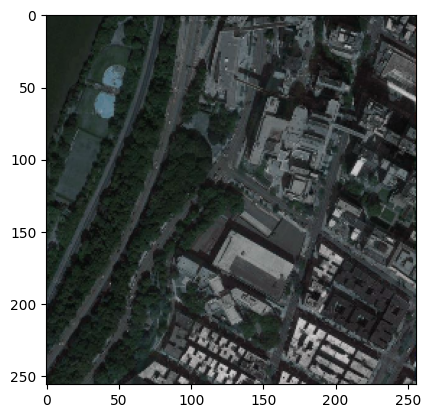

In [ ]:
plt.imshow(src_images[1])

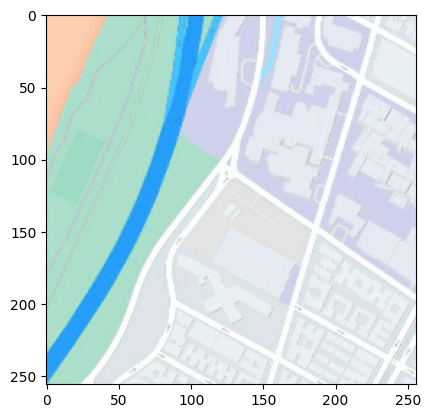

In [ ]:
plt.imshow(target_images[1])

# DISCRIMINATOR MODEL

In [ ]:
def discriminator(image_shape):
  init = keras.initializers.RandomNormal(stddev=0.02)

  in_src_image = keras.Input(shape=image_shape)
  in_target_image = keras.Input(shape=image_shape)
  merged = keras.layers.concatenate([in_src_image, in_target_image])

  #layers
  d = keras.layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(merged)
  d = keras.layers.LeakyReLU(alpha=0.2)(d)

  d = keras.layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
  d = keras.layers.BatchNormalization()(d)
  d = keras.layers.LeakyReLU(alpha=0.2)(d)

  d = keras.layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
  d = keras.layers.BatchNormalization()(d)
  d = keras.layers.LeakyReLU(alpha=0.2)(d)

  d = keras.layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
  d = keras.layers.BatchNormalization()(d)
  d = keras.layers.LeakyReLU(alpha=0.2)(d)

  d = keras.layers.Conv2D(1, (4, 4), padding='same', kernel_initializer=init)(d)
  out = keras.layers.Activation('sigmoid')(d)

  model = keras.Model([in_src_image, in_target_image], out)

  model.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5,
                                                                                beta_2 = 0.009),loss_weights = [0.5], metrics = ['accuracy'])

  return model

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


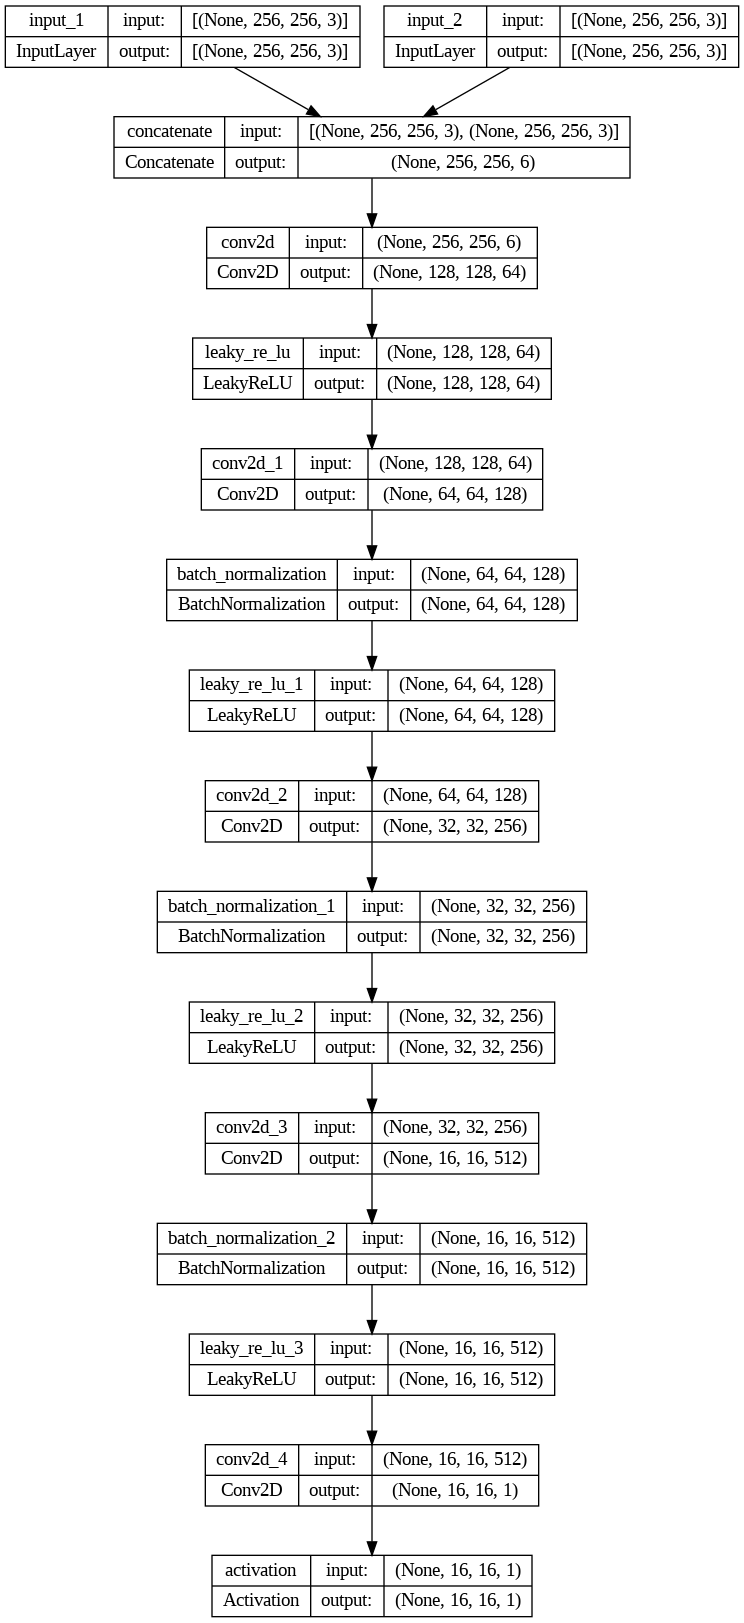

In [ ]:
discriminator_model = discriminator((256, 256, 3))
keras.utils.plot_model(discriminator_model, show_shapes=True, show_layer_names=True)

# GENERATOR MODEL

In [ ]:
def encoder_block(layer_input, filters, batch_norm=True):
  init = keras.initializers.RandomNormal(stddev=0.02)
  g = keras.layers.Conv2D(filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_input)

  if batch_norm:
    g = keras.layers.BatchNormalization()(g, training=True)
  g = keras.layers.LeakyReLU(alpha = 0.2)(g)
  return g

In [ ]:
def decoder_block(layer_input, skip_in, filters, dropout=True):
  init = keras.initializers.RandomNormal(stddev=0.02)
  g = keras.layers.Conv2DTranspose(filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_input)
  g = keras.layers.BatchNormalization()(g, training=True)
  if dropout:
    g = keras.layers.Dropout(0.5)(g, training = True)
  g = keras.layers.concatenate([g, skip_in])
  g = keras.layers.ReLU()(g)
  return g

In [ ]:
def generator(image_shape=(256, 256, 3)):
  init = keras.initializers.RandomNormal(stddev=0.02)

  in_image = keras.Input(shape=image_shape)

  e1 = encoder_block(in_image, 64, batch_norm = False)
  e2 = encoder_block(e1, 128)
  e3 = encoder_block(e2, 256)
  e4 = encoder_block(e3, 512)
  e5 = encoder_block(e4, 512)
  e6 = encoder_block(e5, 512)
  e7 = encoder_block(e6, 512)

  b = keras.layers.Conv2D(512, (4, 4), strides = (2, 2), padding = 'same',
                          kernel_initializer = init, activation = 'relu')(e7)

  d1 = decoder_block(b, e7, 512)
  d2 = decoder_block(d1, e6, 512)
  d3 = decoder_block(d2, e5, 512)
  d4 = decoder_block(d3, e4, 512, dropout = False)
  d5 = decoder_block(d4, e3, 256, dropout = False)
  d6 = decoder_block(d5, e2, 128, dropout = False)
  d7 = decoder_block(d6, e1, 64, dropout = False)

  out_image = keras.layers.Conv2DTranspose(image_shape[2], (4, 4), strides = (2, 2), padding = 'same',
                                           kernel_initializer = init, activation = 'relu')(d7)
  model = keras.Model(in_image, out_image)

  return model

In [ ]:
generator_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 128, 128, 64)         3136      ['input_3[0][0]']             
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)   (None, 128, 128, 64)         0         ['conv2d_5[0][0]']            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 64, 64, 128)          131200    ['leaky_re_lu_4[0][0]']       
                                                                                            

In [ ]:
generator_model = generator()

In [ ]:
def GAN(generator, discriminator, image_shape):
  for layer in discriminator_model.layers:
    if not isinstance(layer, keras.layers.BatchNormalization):
      layer.trainable = False # discriminator layers are set to untrainable

  in_src = keras.Input(shape=image_shape)
  gen_out = generator_model(in_src)
  dis_out = discriminator_model([in_src, gen_out])
  model = keras.Model(in_src, [dis_out, gen_out])

  model.compile(loss = ['binary_crossentropy', 'mae'], optimizer = keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5,
                                                                                          beta_2 = 0.999), metrics = ['accuracy'],
                loss_weights = [1, 100])
  return model

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape):
  train_A, train_B = dataset
  ix = np.random.randint(0, train_A.shape[0], n_samples)
  X1, X2 = train_A[ix], train_B[ix]
  y = np.ones((n_samples, patch_shape, patch_shape, 1))
  return [X1, X2], y

In [ ]:
def generate_fake_samples(generator, samples, patch_shape):
  X = generator.predict(samples)
  y = np.zeros((len(X), patch_shape, patch_shape, 1))
  return X, y

In [ ]:
def train(discriminator, generator, gan, dataset, n_epochs=100, n_batch=1):
  with tf.device("/device:GPU:0"):
    n_patch = discriminator.output_shape[1]

    #unpack the dataset
    train_A, train_B = dataset

    batch_per_epoch = 274

    for i in range(n_epochs):
      for j in range(batch_per_epoch):
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        X_fakeB, y_fake = generate_fake_samples(generator, X_realA, n_patch)
        d_loss1, _ = discriminator.train_on_batch([X_realA, X_realB], y_real, return_dict = True)
        d_loss2, _ = discriminator.train_on_batch([X_realA, X_fakeB], y_fake, return_dict = True)
        gan_loss, _, _, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB], return_dict = True)
      print('Epoch:{}, d_loss_real:{}, d_loss_fake{}, gan_loss{}'.format(i+1, d_loss1, d_loss2, gan_loss))



#TRAINING

In [ ]:
gan_model = GAN(generator_model, discriminator_model, (256, 256, 3))

In [ ]:
print(generator_model)

In [ ]:
print(discriminator_model)

In [ ]:
print(gan_model)

In [ ]:
src_images = np.array(src_images)
target_images = np.array(target_images)

In [ ]:
dataset = [src_images, target_images]
train(discriminator_model, generator_model, gan_model, dataset, n_epochs = 50)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 25ms/step
Epoch:32, d_loss_real:loss, d_loss_fakeloss, gan_lossloss
1/1 [==============================] - 0s 27ms/step
Epoch:33, d_loss_real:loss, d_loss_fakeloss, gan_lossloss
1/1 [==============================] - 0s 25ms/step
Epoch:34, d_loss_real:loss, d_loss_fakeloss, gan_lossloss
1/1 [==============================] - 0s 25ms/step
Epoch:35, d_loss_real:loss, d_loss_fakeloss, gan_lossloss
1/1 [==============================] - 0s 31ms/step
Epoch:36, d_loss_real:loss, d_loss_fakeloss, gan_lossloss
1/1 [==============================] - 0s 27ms/step
Epoch:37, d_loss_real:loss, d_loss_fakeloss, gan_lossloss
1/1 [==============================] - 0s 25ms/step
Epoch:38, d_loss_real:loss, d_loss_fakeloss, gan_lossloss
1/1 [==============================] - 0s 25ms/step
Epoch:39, d_loss_real:loss, d_loss_fakeloss, gan_lossloss
1/1 [==============================] - 0s 29ms/step
Epoch:40, d_loss_

1/1 [==============================] - 0s 31ms/step


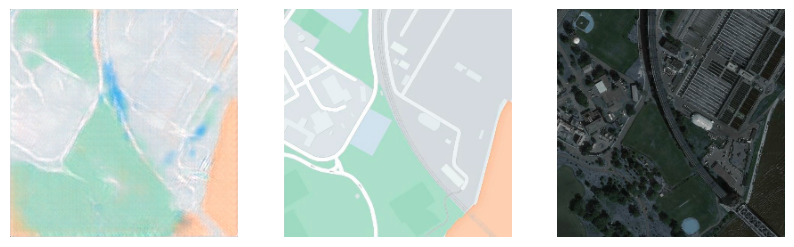

In [ ]:
[X1, X2] = dataset
# select random example
ix = np.random.randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = generator_model.predict(src_image)
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1, 3, 1)
ax1.axis('off')
plt.imshow(gen_image[0])
ax2 = fig.add_subplot(1, 3, 2)
ax2.axis('off')
plt.imshow(tar_image[0])
ax3 = fig.add_subplot(1, 3, 3)
ax3.axis('off')
plt.imshow(src_image[0])